<h2><b> Social network Graph Link Prediction</b></h2>

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as ntx


from sklearn.metrics import f1_score
from pandas import read_hdf
from xgboost import XGBClassifier
from scipy.stats import randint as sp_randint
from scipy.sparse.linalg import svds
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
pip install tables

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
train_df = read_hdf('/home/goggi_bhargav/storage_sample_stage4.h5', 'train_df',mode='r')
test_df = read_hdf('/home/goggi_bhargav/storage_sample_stage4.h5', 'test_df',mode='r')

In [3]:
train_df.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

Constructing graph from train data

In [4]:
tr_graph=ntx.read_edgelist('/home/goggi_bhargav/train_pos_after_eda.csv',delimiter=',',create_using=ntx.DiGraph(),nodetype=int)
print(ntx.info(tr_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


Getting target labels

In [5]:
y_train = train_df.indicator_link
y_test = test_df.indicator_link

Adding features named preferential attachments with followers and followees

In [6]:
def preferrential_attachment_for_followees(src,dst):
    try:
        if(len(set(tr_graph.successors(src)))==0 | len(set(tr_graph.successors(dst)))==0):
            return 0
        prefatt = (len(set(tr_graph.successors(src)))) * (len(set(tr_graph.successors(dst))))
    except:
        return 0
    return prefatt

In [7]:
def preferrential_attachment_for_followers(src,dst):
    try:
        if(len(set(tr_graph.predecessors(src)))==0 | len(set(tr_graph.predecessors(dst)))==0):
            return 0
        prefatt = (len(set(tr_graph.predecessors(src)))) * (len(set(tr_graph.predecessors(dst))))
    except:
        return 0
    return prefatt

In [8]:
# Refered this code from FB_Models and FB_featurization

train_df['preferrential_attachment_for_followees'] = train_df.apply(lambda row:preferrential_attachment_for_followees(row['source_node'],row['destination_node']),axis=1)
train_df['preferrential_attachment_for_followers'] = train_df.apply(lambda row:preferrential_attachment_for_followers(row['source_node'],row['destination_node']),axis=1)

test_df['preferrential_attachment_for_followees'] = test_df.apply(lambda row:preferrential_attachment_for_followees(row['source_node'],row['destination_node']),axis=1)
test_df['preferrential_attachment_for_followers'] = test_df.apply(lambda row:preferrential_attachment_for_followers(row['source_node'],row['destination_node']),axis=1)


In [9]:
train_df.head()
#print('\n----------------------------\n')
#print(test_df.head())

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferrential_attachment_for_followees,preferrential_attachment_for_followers
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,120,66
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,8662,1598
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,902,980
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,35,22
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,33,5


Computing SVD features for source and destination

In [10]:
#Reference: This snippet of code has been taken from reference notebooks

def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [11]:
sadj_col = sorted(tr_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [12]:
Adj = ntx.adjacency_matrix(tr_graph,nodelist=sorted(tr_graph.nodes())).asfptype()

In [13]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [15]:
train_df['src_svd_dot'] = train_df.apply(lambda row: np.dot(np.array(svd(row['source_node'],U)),np.array(svd(row['destination_node'],U))),axis=1) 
train_df['dest_svd_dot'] = train_df.apply(lambda row: np.dot(np.array(svd(row['source_node'],V.T)),np.array(svd(row['destination_node'],V.T))),axis=1) 

test_df['src_svd_dot'] = test_df.apply(lambda row: np.dot(np.array(svd(row['source_node'],U)),np.array(svd(row['destination_node'],U))),axis=1)
test_df['dest_svd_dot'] = test_df.apply(lambda row: np.dot(np.array(svd(row['source_node'],V.T)),np.array(svd(row['destination_node'],V.T))),axis=1)

Creating final train and test data by dropping source node, destination node and indicator link

In [16]:
X_train = train_df.drop(['source_node','destination_node','indicator_link'],axis=1)
X_test = test_df.drop(['source_node','destination_node','indicator_link'],axis=1)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(100002, 55)
(100002,)
(50002, 55)
(50002,)


Hyper parameter tuning for XGBoost with all the features

In [27]:
#Reference: https://xgboost.readthedocs.io/en/latest/python/python_api.html
import datetime
start = datetime.datetime.now()
params = {
    "n_estimators": sp_randint(105,125),
    "max_depth": [1,3,5,7,9],
    "learning_rate": [0.001,0.01,0.1,0.2,0.3],
    "colsample_bytree": [0.2,0.4,0.6,0.8,1.0]
}

xgbclf = XGBClassifier(objective='binary:logistic',eval_metric='logloss')
ransrch = RandomizedSearchCV(xgbclf,params,cv=3,scoring='f1',n_iter=20,return_train_score=True)
ransrch.fit(X_train,y_train)
print("Time taken for tuning hyper parameters",datetime.datetime.now()-start)

Time taken for tuning hyper parameters 0:07:53.290832


Obtaining the best hyper parameters

In [19]:
ransrch.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.3,
 'max_depth': 9,
 'n_estimators': 121}

Modelling with best parameters

In [20]:
start = datetime.datetime.now()
optimal_xgbclf = XGBClassifier(n_estimators=ransrch.best_params_.get('n_estimators'),
                              max_depth = ransrch.best_params_.get('param_max_depth'),
                              learning_rate = ransrch.best_params_.get('param_learning_rate'),
                              colsample_bytree = ransrch.best_params_.get('param_colsample_bytree'))

optimal_xgbclf.fit(X_train,y_train,eval_metric='logloss')
print(datetime.datetime.now()-start,'Time was taken for modelling')

0:00:24.280522 Time was taken for modelling


In [21]:
train_predict = optimal_xgbclf.predict(X_train)
test_predict = optimal_xgbclf.predict(X_test)
print("Train F1 Score=",f1_score(y_train,train_predict))
print("Test F1 Score=",f1_score(y_test,test_predict))

Train F1 Score= 0.9966677674041606
Test F1 Score= 0.922525750111957


In [22]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


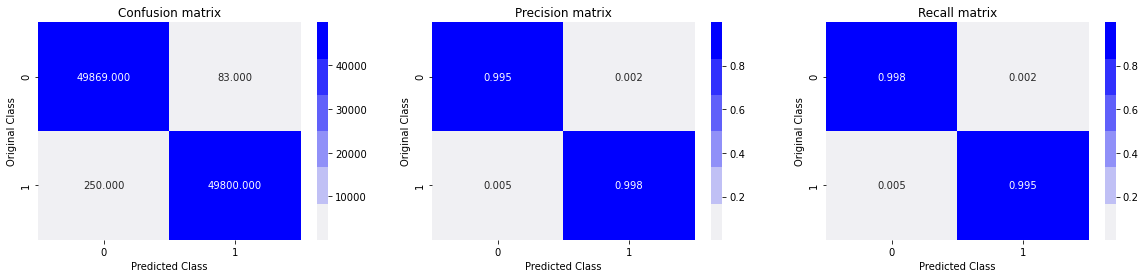




Test confusion_matrix


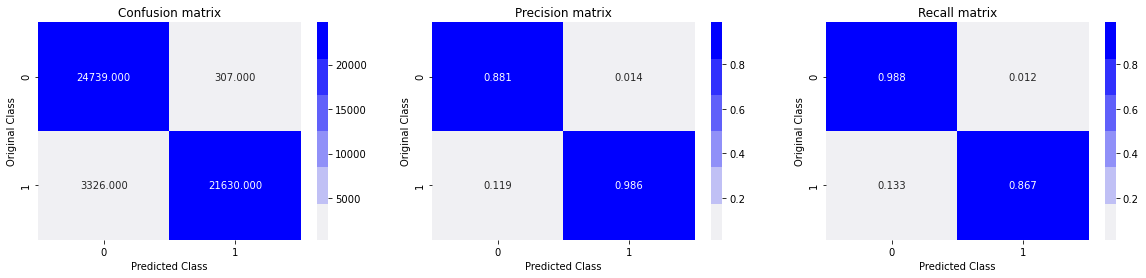

In [23]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,train_predict)
print("\n\n")
print('Test confusion_matrix')
plot_confusion_matrix(y_test,test_predict)

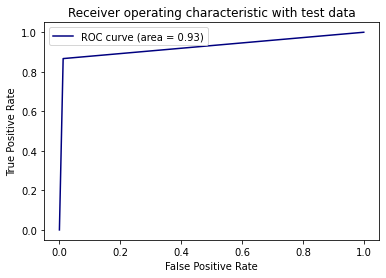

In [24]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,test_predict)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

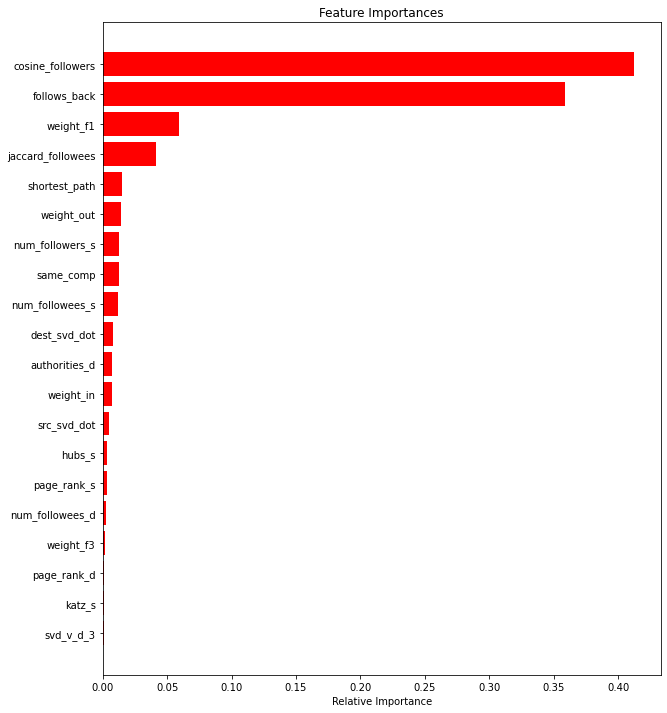

In [25]:
features = X_train.columns
importances = optimal_xgbclf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<h3><b> Step by step procedure followed to solve this case study </b></h3>

1. Created a graph, and obtained total number of nodes, edges from training data, where data consists of all positive points

2. Till now we have obtained only positive datapoints. Now to obtain negative points, we will consider all missing edges as negative points.

3. We, then splitted the data into train and test data.

4. Then we have added few graph based features like PageRank, Jaccard distance, Cosine distance, Adar index, Katz centrality etc. 

5. We have also added two more features, preferrential_attachemnt and SVD_dot for both source and destination nodes in this particular assignment.

6. Then we performed hyper parameter tuning for XGBoost using RandomizedSearchCV.

7. Finally we plotted confusion matrix for train and test to visualize the results. Also we have plotted horizontal bar graph to visualize features which are important for prediction.